In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import libraries

In [1]:
# import libraries
!pip install opencv-python
import sklearn
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr, kendalltau
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Disattiva tutti i warning
import warnings
warnings.filterwarnings('ignore')

You should consider upgrading via the 'c:\users\miche\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
# set True if you have and you want to use the 16 GB RAM (it will be faster)
RAM_16_GB = False

# Loading dataset

In [3]:
dataset_path='C:/Users/miche/Desktop/anemia-detection/database_sclere/'   # modify the dataset_path to your own dir
assert dataset_path!='' and dataset_path!='/path/to/dataset/', 'Please specify the dataset_path!'

# load csv file
df = pd.read_csv(dataset_path+'hbvalue.csv', sep=';')

# cut the dataset only to ind and ita dataset
df = df[(df['dataset']=='ind') | (df['dataset']=='ita')]

df.head()


,dataset,paziente,foto1,foto2,hb,Nome Cognome,Sesso,Et?,Data Nascita,buona,Unnamed: 10
0,ita,T_1,92317,92247,"14,1",Caterina Antonacci,F,40,1979.0,NaN,NaN
1,ita,T_2,93707,93702,"13,9",Maria Campobasso,F,34,1985.0,NaN,NaN
2,ita,T_3,94015,94012,"14,1",Vitangelo Lops,M,53,1966.0,NaN,NaN
3,ita,T_4,95329,95326,"15,7",Maro Mahdal,M,36,1983.0,NaN,NaN
4,ita,T_5,74439,74432,"13,9",Giuseppe Rosario Barile,M,51,1968.0,NaN,NaN


# Lists initialization

In [4]:
#BGR
vessels_density = []

value_r_minous_g_img_sclera = []
value_r_minous_g_img_vessels = []

sclera_quantiles_bgr = []
vessels_quantiles_bgr = []

dev_std_sclera = []
dev_std_vessels = []

#Lab
vessels_density_lab = []

value_a_img_sclera = []
value_a_img_vessels = []

sclera_quantiles_lab = []
vessels_quantiles_lab = []

dev_std_sclera_cielab = []
dev_std_vessels_cielab = []

vessels_colors_white_deviations_cielab = []
vessels_colors_white_quantiles_cielab = []

# Loading photos

## Before running this block: 

You need to execute these blocks in this order: 
 1. Loading italian photos (make sure you don't run Loading indian photos)
 2. preprocessing
 3. mask application
 4. metrics calculation (BGR)
 5. conversion in Lab
 6. contrast enhancement
 7. metrics calculation (Lab)
 8. extract white of sclera

After you can Load indian photos and re-execute blocks from 2 to 8.

### Loading italian photos

In [5]:
sclera_vessels = []
sclera_masks = []

filtered_df = df.loc[df['dataset'] == 'ita']

# iterates on the Italian dataset
for index, row in tqdm(filtered_df.iterrows(), total=filtered_df.shape[0]):

    path_photos = dataset_path+'Italiano congiuntive/Dataset congiuntive italiano segmentato/'
    paziente = row['paziente'] + "_"

    # search folder
    matching_folders = []
    for folder_name in os.listdir(path_photos):
        if folder_name.startswith(paziente) and os.path.isdir(os.path.join(path_photos, folder_name)):
            path_single_photo = os.path.join(path_photos, folder_name)

            name_photo = folder_name.split("-")[-1]
            # load sclera
            sclera_mask = cv2.imread(path_single_photo + "/" + name_photo + '_sclera.png')
            sclera_masks.append(sclera_mask)

            # load mask
            sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto_deep.png', cv2.IMREAD_UNCHANGED)

            if sclera_vessel is None:
                sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto.png', cv2.IMREAD_UNCHANGED)

            sclera_vessels.append(sclera_vessel)
            break


100%|██████████| 91/91 [00:13<00:00,  6.56it/s]


### Loading indian photos

In [6]:

filtered_df = df.loc[df['dataset'] == 'ind']

# iterates on Indian dataset
for index, row in tqdm(filtered_df.iterrows(), total=filtered_df.shape[0]):


    path_photos = dataset_path+'Dataset indiano/'
    paziente = row['paziente'] + "-"

    # search folder
    matching_folders = []
    for folder_name in os.listdir(path_photos):
        if folder_name.startswith(paziente) and os.path.isdir(os.path.join(path_photos, folder_name)):
            path_single_photo = os.path.join(path_photos, folder_name)

            name_photo = folder_name.split("-")[-1]
            # load sclera
            sclera_mask = cv2.imread(path_single_photo + "/" + name_photo + '_sclera.png')
            sclera_masks.append(sclera_mask)

            # load mask
            sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto_deep.png', cv2.IMREAD_UNCHANGED)

            if sclera_vessel is None:
                sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto.png', cv2.IMREAD_UNCHANGED)

            sclera_vessels.append(sclera_vessel)
            break


100%|██████████| 95/95 [00:14<00:00,  6.75it/s]


# Preprocessing

100%|██████████| 186/186 [00:00<00:00, 1413.59it/s]


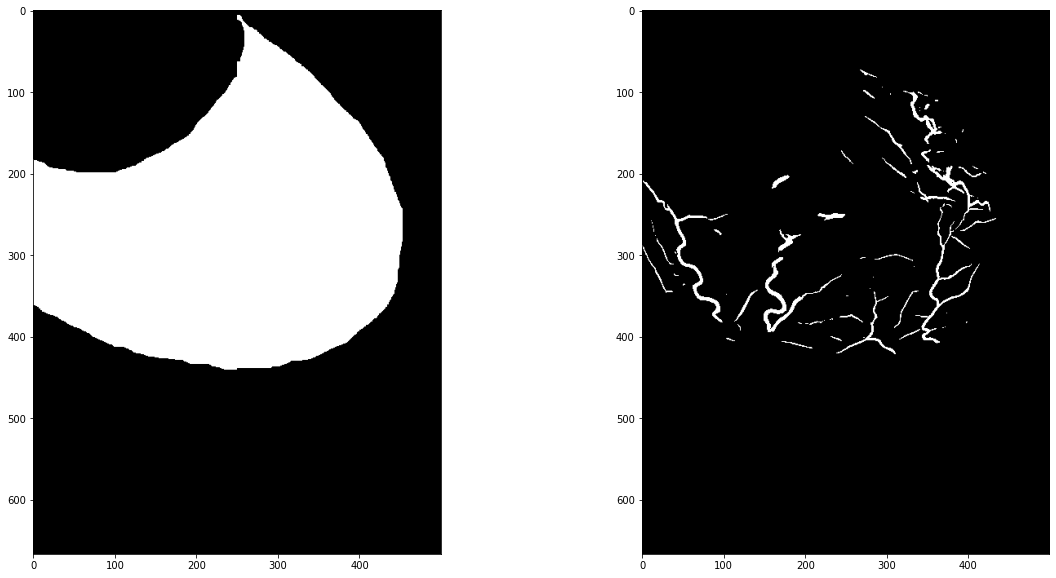

In [7]:
sclera_vessels_shape = sclera_vessels[0].shape
sclera_masks_bw = []                                # array of black and white sclera
sclera_vessels_bw = []                              # array of black and white sclera vessels

# converts the sclera masks to black and white
for index, mask in tqdm(enumerate(sclera_masks), total=len(sclera_masks)):
    # resize the mask to the sclera vessel shape
    mask = cv2.resize(mask, sclera_vessels_shape[:2][::-1])

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    _, mask = cv2.threshold(mask, 2, 255, cv2.THRESH_BINARY)

    sclera_masks_bw.append(mask)

# converts the sclera vessels to black and white
for index, mask in tqdm(enumerate(sclera_vessels), total=len(sclera_vessels)):
    # transparence becomes black
    mask[mask[:, :, 3] == 0] = [0, 0, 0, 0]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    _, mask = cv2.threshold(mask, 2, 255, cv2.THRESH_BINARY)

    sclera_vessels_bw.append(mask)

# show the sclera masks and sclera vessels
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(sclera_masks_bw[1], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(sclera_vessels_bw[1], cmap='gray')
plt.show()

# Mask application

100%|██████████| 186/186 [00:13<00:00, 14.18it/s]


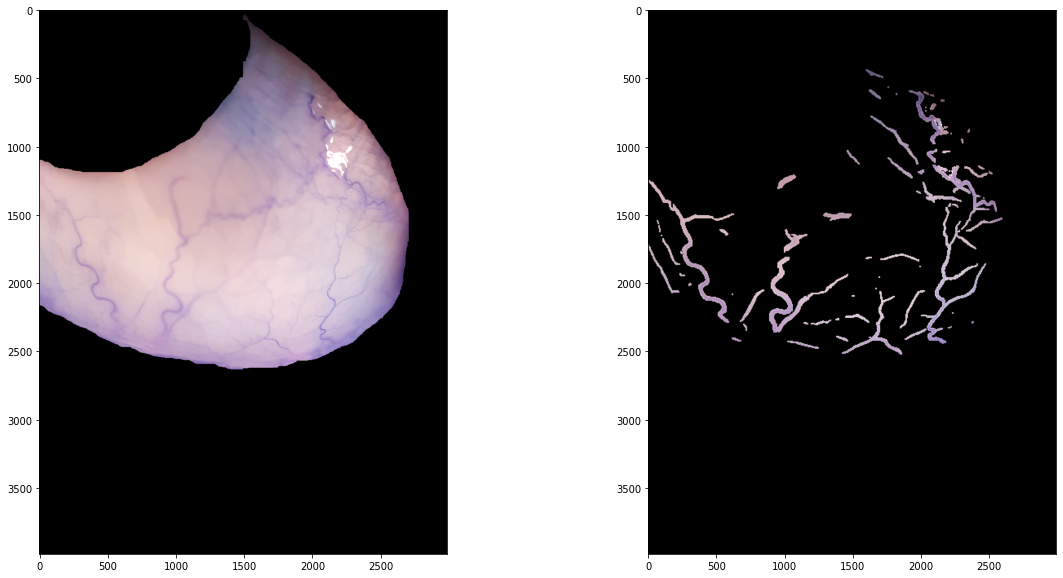

In [8]:
sclera_masked = []                                    # array of sclera with only sclera part is coloured
sclera_vessels_masked = []                            # array of sclera with only sclera part is coloured


if not RAM_16_GB:
    np.save("sclera_masks.npy", sclera_masks)
    np.save("sclera_masks_bw.npy", sclera_masks_bw)
    np.save("sclera_vessels.npy", sclera_vessels)
    np.save("sclera_vessels_bw.npy", sclera_vessels_bw)


for l in tqdm(range(len(sclera_masks_bw))):
    sclera_masked.append(sclera_masks[l])
    sclera_masks_bw[l] =  cv2.resize(sclera_masks_bw[l], sclera_masked[l].shape[:2][::-1])
    sclera_masked[l] = cv2.bitwise_and(sclera_masked[l], sclera_masked[l], mask=sclera_masks_bw[l])                  # if mask pixel is black


# delete masks lists
if not RAM_16_GB:
    del sclera_masks_bw
    del sclera_masks

for l in tqdm(range(len(sclera_vessels_bw))):
    sclera_vessels_masked.append(sclera_masked[l])
    sclera_vessels_bw[l] =  cv2.resize(sclera_vessels_bw[l], sclera_vessels_masked[l].shape[:2][::-1])
    sclera_vessels_masked[l] = cv2.bitwise_and(sclera_vessels_masked[l], sclera_vessels_masked[l], mask=sclera_vessels_bw[l])                  # if mask pixel is black

# delete vessels lists
if not RAM_16_GB:
    del sclera_vessels_bw
    del sclera_vessels

# show resulting image
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(sclera_masked[1])
plt.subplot(1, 2, 2)
plt.imshow(sclera_vessels_masked[1])
plt.show()


# Metrics calculation (BGR)

In [9]:

# sclera_masked
# sclera_vessels_masked

# calculate the metrics
number_sclera_pixel = 0
number_vessels_pixel = 0
number_sclera_pixel_coulored = 0
number_vessels_pixel_coulored = 0

b = 0
g = 0
r = 0

value_r_minous_g_pixel_sclera = 0
value_r_minous_g_pixel_vessels = 0


for l in tqdm(range(len(sclera_masked))):                               # Per ogni immagine della sclera
    number_sclera_pixel = 0
    number_vessels_pixel = 0
    value_r_minous_g_pixel_sclera = 0
    value_r_minous_g_pixel_vessels = 0

    # counts coloured pixels
    img_gray = cv2.cvtColor(sclera_masked[l], cv2.COLOR_BGR2GRAY)
    _, img_binaria = cv2.threshold(img_gray, 1, 255, cv2.THRESH_BINARY)
    number_sclera_pixel_coulored = cv2.countNonZero(img_binaria)

    # counts total pixels
    number_sclera_pixel = img_binaria.size

    # sclera quantile initialization
    b, g, r = cv2.split(sclera_masked[l])
    value_r_minous_g_pixel_sclera = np.sum(r/10) - np.sum(g/10)

    std_sclera = cv2.meanStdDev(r-g)[1]

    quantile = np.empty((3, 3))
    filtered_bgr = sclera_masked[l][:, :, 0]
    filtered_bgr = filtered_bgr[filtered_bgr != 0]

    # calculate all three quantiles
    quantile[0] = np.quantile(filtered_bgr, [0.25, 0.5, 0.75])

    filtered_bgr = sclera_masked[l][:, :, 1]
    filtered_bgr = filtered_bgr[filtered_bgr != 0]

    quantile[1] = np.quantile(filtered_bgr, [0.25, 0.5, 0.75])

    filtered_bgr = sclera_masked[l][:, :, 2]
    filtered_bgr = filtered_bgr[filtered_bgr != 0]

    quantile[2] = np.quantile(filtered_bgr, [0.25, 0.5, 0.75])
    sclera_quantiles_bgr.append(quantile)

    # count coloured pixels
    img_gray = cv2.cvtColor(sclera_vessels_masked[l], cv2.COLOR_BGR2GRAY)
    _, img_binaria = cv2.threshold(img_gray, 1, 255, cv2.THRESH_BINARY)
    number_vessels_pixel_coulored = cv2.countNonZero(img_binaria)

    # count total pixels
    number_vessels_pixel = img_binaria.size

    # calculate the difference between r and g channel
    b, g, r = cv2.split(sclera_vessels_masked[l])
    value_r_minous_g_pixel_vessels = np.sum(r/10) - np.sum(g/10)

    std_vessels = cv2.meanStdDev(r-g)[1]

    # sclera quantile initialization
    quantile = np.empty((3, 3))
    filtered_bgr = sclera_vessels_masked[l][:, :, 0]
    filtered_bgr = filtered_bgr[filtered_bgr != 0]

    # calculate all three quantiles
    quantile[0] = np.quantile(filtered_bgr, [0.25, 0.5, 0.75])

    filtered_bgr = sclera_vessels_masked[l][:, :, 1]
    filtered_bgr = filtered_bgr[filtered_bgr != 0]

    quantile[1] = np.quantile(filtered_bgr, [0.25, 0.5, 0.75])

    filtered_bgr = sclera_vessels_masked[l][:, :, 2]
    filtered_bgr = filtered_bgr[filtered_bgr != 0]

    quantile[2] = np.quantile(filtered_bgr, [0.25, 0.5, 0.75])
    vessels_quantiles_bgr.append(quantile)

    vessels_density.append(number_vessels_pixel_coulored/number_sclera_pixel_coulored)
    #print("il valore di densità dei pixel dei vasi rispetto ai pixel della sclera per la", l+1, "° immagine è: ", vessels_density[l])
    value_r_minous_g_img_sclera.append(value_r_minous_g_pixel_sclera/number_sclera_pixel)
    #print("il valore medio dei pixel della sclera, calcolati come R - G, per la", l+1, "° immagine è: ",value_r_minous_g_img_sclera[l])
    value_r_minous_g_img_vessels.append(value_r_minous_g_pixel_vessels/number_vessels_pixel)
    #print("il valore medio dei pixel dei vasi, calcolati come R - G, per la", l+1, "° immagine è: ", value_r_minous_g_img_vessels[l])

    dev_std_sclera.append(std_sclera)
    dev_std_vessels.append(std_vessels)

    #print("i quantili della sclera", l+1, "° sono:\n", sclera_quantiles_bgr[l])
    #print("i quantili dei vasi", l+1, "° sono:\n", vessels_quantiles_bgr[l])



100%|██████████| 186/186 [01:14<00:00,  2.51it/s]


# Conversion cielab, increase contrast and clahe equalitation (optional)

If you don't want to use clahe equalitation use the first cell, otherwise use the second

### Without clahe eq.

100%|██████████| 186/186 [00:11<00:00, 15.56it/s]


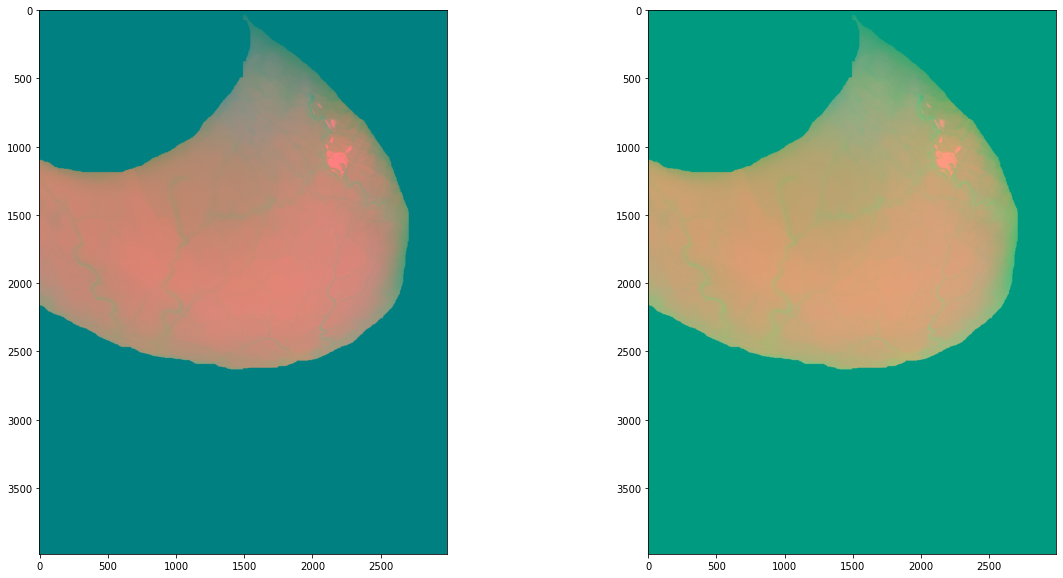

100%|██████████| 186/186 [01:31<00:00,  2.03it/s]


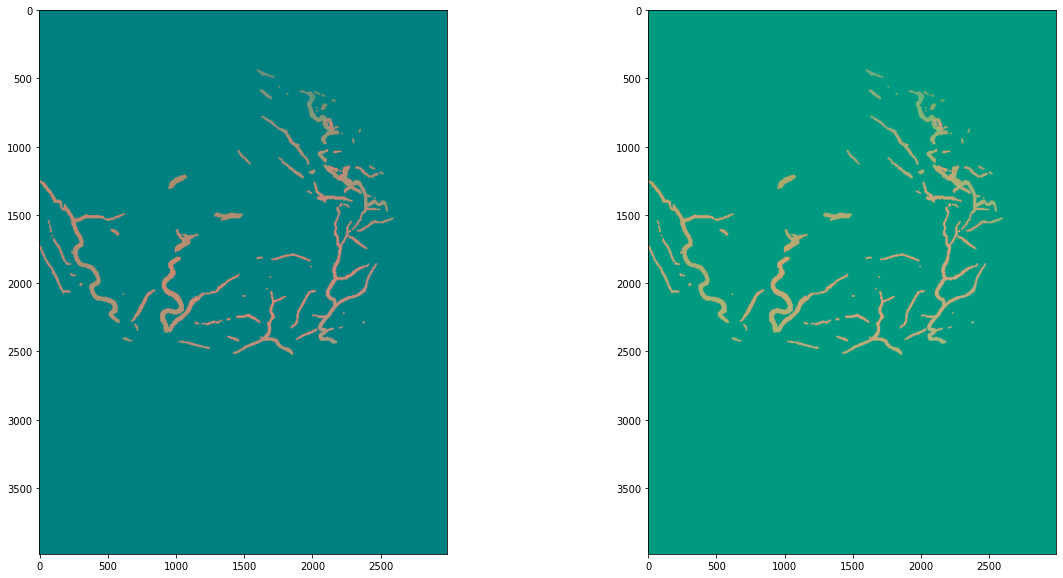

In [10]:
sclera_lab = []
sclera_vessels_lab = []

sclera_es = cv2.cvtColor(sclera_masked[1], cv2.COLOR_BGR2LAB)       # saving an image to compare with a converted one

for i in tqdm(range(len(sclera_masked))):

  # format conversion --> contrast enhancement --> insertion in list
  img_lab = cv2.cvtColor(sclera_masked[i], cv2.COLOR_BGR2LAB)
  img_lab[:, :, 1] = cv2.multiply(img_lab[:, :, 1], 1.2)
  sclera_lab.append(img_lab)


del sclera_masked

# Comparison between image with and without contrast enhancement
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(sclera_es)
plt.subplot(1, 2, 2)
plt.imshow(sclera_lab[1])
plt.show()

# Convert vessels to Lab format
vessel_es = cv2.cvtColor(sclera_vessels_masked[1], cv2.COLOR_BGR2LAB)       # saving an image to compare with a converted one
for i in tqdm(range(len(sclera_vessels_masked))):

  # format conversion --> contrast enhancement --> insertion in list
  img_lab = cv2.cvtColor(sclera_vessels_masked[i], cv2.COLOR_BGR2LAB)
  img_lab[:, :, 1] = cv2.multiply(img_lab[:, :, 1], 1.2)
  sclera_vessels_lab.append(img_lab)

# Free up memory space
del sclera_vessels_masked

# Comparison between image with and without contrast enhancement
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(vessel_es)
plt.subplot(1, 2, 2)
plt.imshow(sclera_vessels_lab[1])
plt.show()


### With also clahe eq.

100%|██████████| 186/186 [02:14<00:00,  1.39it/s]


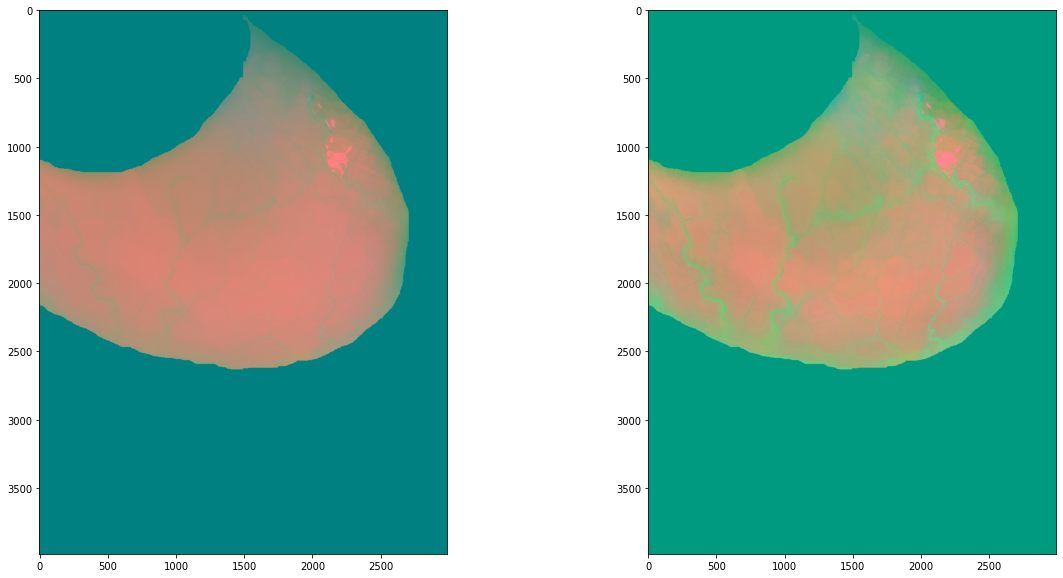

100%|██████████| 186/186 [02:23<00:00,  1.30it/s]


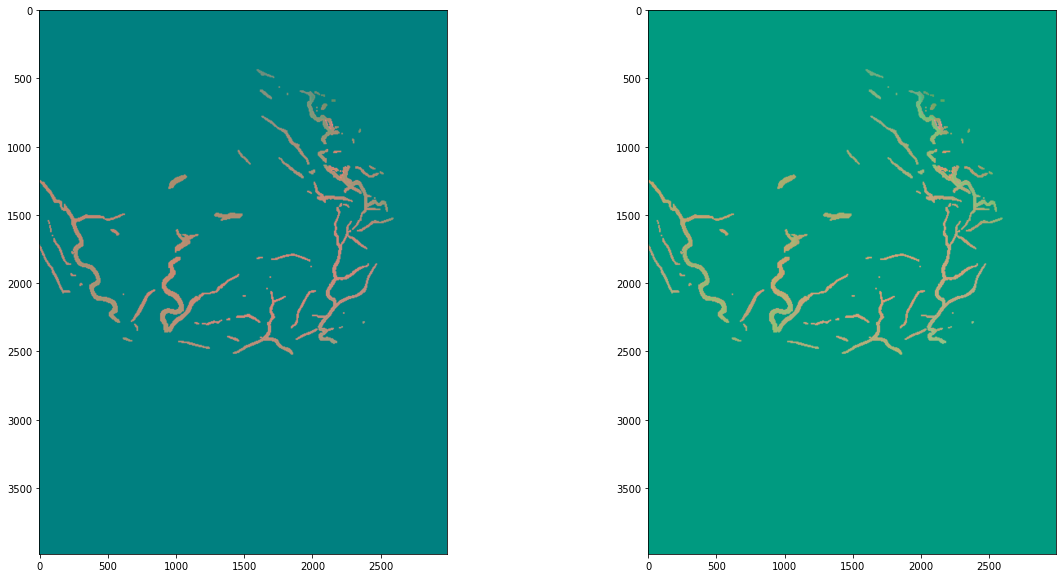

In [10]:
sclera_lab = []
sclera_vessels_lab = []

sclera_es = cv2.cvtColor(sclera_masked[1], cv2.COLOR_BGR2LAB)       # saving an image to compare with a converted one

for l in tqdm(range(len(sclera_masked))):

  # format conversion --> contrast enhancement --> insertion in list
  img_lab = cv2.cvtColor(sclera_masked[l], cv2.COLOR_BGR2LAB)

  # Applies adaptive histogram equalization to all channels (L, a, b) of the Lab image
  clahe = cv2.createCLAHE(clipLimit=1.82, tileGridSize=(8, 8))
  image_lab_eq = img_lab.copy()
  for i in range(3):
    image_lab_eq[:, :, i] = clahe.apply(image_lab_eq[:, :, i])

  # Applies contrast to Lab image
  image_lab_eq[:, :, 1] = cv2.multiply(image_lab_eq[:, :, 1], 1.2)

  L1, a1, b1 = cv2.split(img_lab)
  L2, a2, b2 = cv2.split(image_lab_eq)
  m = cv2.inRange(img_lab, (0, 128, 128), (0, 128, 128))

  result_L2 = cv2.bitwise_and(L2, L2, mask=~m)
  result_a2 = cv2.bitwise_and(a2, a2, mask=~m)
  result_b2 = cv2.bitwise_and(b2, b2, mask=~m)
  image_lab_eq = cv2.merge((result_L2, result_a2, result_b2))

  # Crea una maschera dei pixel neri
  black_pixels = (image_lab_eq == [0, 0, 0]).all(axis=2)
  # Applica la maschera per convertire solo i pixel neri
  image_lab_eq[black_pixels] = [0, 154, 128]

  sclera_lab.append(image_lab_eq)

del img_lab, clahe, image_lab_eq, L1, a1, b1, L2, a2, b2, m, result_L2, result_a2, result_b2, black_pixels
del sclera_masked

# Comparison between image with and without contrast enhancement
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(sclera_es)
plt.subplot(1, 2, 2)
plt.imshow(sclera_lab[1])
plt.show()

# Lab vessels conversion
vessel_es = cv2.cvtColor(sclera_vessels_masked[1], cv2.COLOR_BGR2LAB)       # saving an image to compare with a converted one
for l in tqdm(range(len(sclera_vessels_masked))):

  # format conversion --> contrast enhancement --> insertion in list
  img_lab = cv2.cvtColor(sclera_vessels_masked[l], cv2.COLOR_BGR2LAB)

  # Applies adaptive histogram equalization to all channels (L, a, b) of the Lab image
  clahe = cv2.createCLAHE(clipLimit=1.6, tileGridSize=(8, 8))
  image_lab_eq = img_lab.copy()
  for i in range(3):
    image_lab_eq[:, :, i] = clahe.apply(image_lab_eq[:, :, i])

  # Apply contrast
  image_lab_eq[:, :, 1] = cv2.multiply(image_lab_eq[:, :, 1], 1.2)
  
  L1, a1, b1 = cv2.split(img_lab)
  L2, a2, b2 = cv2.split(image_lab_eq)
  m = cv2.inRange(img_lab, (0, 128, 128), (0, 128, 128))

  result_L2 = cv2.bitwise_and(L2, L2, mask=~m)
  result_a2 = cv2.bitwise_and(a2, a2, mask=~m)
  result_b2 = cv2.bitwise_and(b2, b2, mask=~m)
  image_lab_eq = cv2.merge((result_L2, result_a2, result_b2))

  # Crea una maschera dei pixel neri
  black_pixels = (image_lab_eq == [0, 0, 0]).all(axis=2)
  # Applica la maschera per convertire solo i pixel neri
  image_lab_eq[black_pixels] = [0, 154, 128]

  sclera_vessels_lab.append(image_lab_eq)

# Free up memory space
del img_lab, clahe, image_lab_eq, L1, a1, b1, L2, a2, b2, m, result_L2, result_a2, result_b2, black_pixels
del sclera_vessels_masked

# Comparison between image with and without contrast enhancement
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(vessel_es)
plt.subplot(1, 2, 2)
plt.imshow(sclera_vessels_lab[1])
plt.show()



## Metrics calculation (Lab)

In [11]:
# Calculate the metrics
number_sclera_pixel = 0
number_vessels_pixel = 0
number_sclera_pixel_coulored = 0
number_vessels_pixel_coulored = 0

L = 0
a = 0
b = 0

value_a_pixel_sclera = 0
value_a_pixel_vessels = 0


for l in tqdm(range(len(sclera_lab))):                               # for each image in sclera_lab
    number_sclera_pixel = 0
    number_vessels_pixel = 0
    value_a_pixel_sclera = 0
    value_a_pixel_vessels = 0


    # count total pixels
    number_sclera_pixel = img_binaria.size

    # Calculate the sum of each a* value
    L, a, b = cv2.split(sclera_lab[l])
    value_a_pixel_sclera = np.sum(a/10)

    std_sclera = cv2.meanStdDev(a)[1]

    # sclera quantile inizialization
    quantile = np.empty((3, 3))
    filtered_lab = sclera_lab[l][:, :, 0]
    filtered_lab = filtered_lab[filtered_lab != 0]

    # calculate all three quantiles
    quantile[0] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])

    filtered_lab = sclera_lab[l][:, :, 1]
    filtered_lab = filtered_lab[filtered_lab != 154]

    quantile[1] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])

    filtered_lab = sclera_lab[l][:, :, 2]
    filtered_lab = filtered_lab[filtered_lab != 128]

    quantile[2] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])
    sclera_quantiles_lab.append(quantile)


    # count coloured pixels
    lab_to_bgr = cv2.cvtColor(sclera_vessels_lab[l], cv2.COLOR_LAB2BGR)
    img_gray = cv2.cvtColor(lab_to_bgr, cv2.COLOR_BGR2GRAY)
    _, img_binaria = cv2.threshold(img_gray, 1, 255, cv2.THRESH_BINARY)
    number_vessels_pixel_coulored = cv2.countNonZero(img_binaria)

    # count total pixels
    number_vessels_pixel = img_binaria.size

    # Calculate the sum of each a* value
    L, a, b = cv2.split(sclera_vessels_lab[l])
    value_a_pixel_vessels = np.sum(a/10)

    std_vessels_L = cv2.meanStdDev(L)[1]
    std_vessels_b = cv2.meanStdDev(b)[1]

    # sclera quantile inizialization
    quantile = np.empty((3, 3))
    filtered_lab = sclera_vessels_lab[l][:, :, 0]
    filtered_lab = filtered_lab[filtered_lab != 0]

    # calculate all three quantiles
    quantile[0] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])

    filtered_lab = sclera_vessels_lab[l][:, :, 1]
    filtered_lab = filtered_lab[filtered_lab != 154]

    quantile[1] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])

    filtered_lab = sclera_vessels_lab[l][:, :, 2]
    filtered_lab = filtered_lab[filtered_lab != 128]

    quantile[2] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])
    vessels_quantiles_lab.append(quantile)


    vessels_density_lab = vessels_density.copy()
    #print("il valore di densità dei pixel dei vasi rispetto ai pixel della sclera per la", l+1, "° immagine è: ", vessels_density[l])
    value_a_img_sclera.append(value_a_pixel_sclera/number_sclera_pixel)
    #print("il valore medio dei pixel della sclera, calcolati come a*, per la", l+1, "° immagine è: ",value_a_img_sclera[l])
    value_a_img_vessels.append(value_a_pixel_vessels/number_vessels_pixel)
    #print("il valore medio dei pixel dei vasi, calcolati come a*, per la", l+1, "° immagine è: ", value_a_img_vessels[l])

    dev_std_sclera_cielab.append(std_sclera)
    dev_std_vessels_cielab.append([std_vessels_L, std_vessels_b])


    #print("i quantili della sclera", l+1, "° sono:\n", sclera_quantiles_lab[l])
    #print("i quantili dei vasi", l+1, "° sono:\n", vessels_quantiles_lab[l])



del sclera_lab
del sclera_vessels_lab

100%|██████████| 186/186 [01:30<00:00,  2.06it/s]


# Extract white of sclera

100%|██████████| 186/186 [01:18<00:00,  2.36it/s]


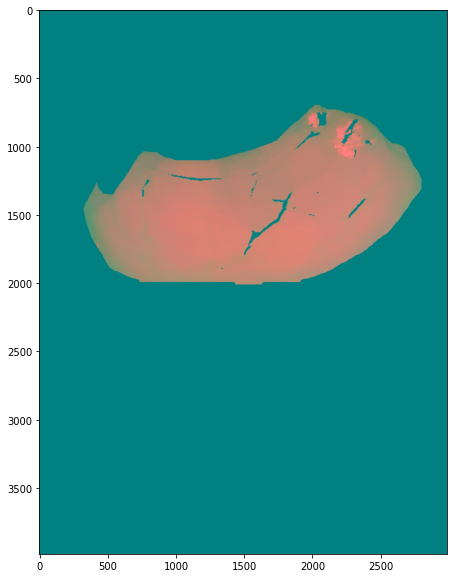

In [12]:
if not RAM_16_GB:
        sclera_masks = np.load("sclera_masks.npy")
        sclera_masks_bw = np.load("sclera_masks_bw.npy")
        sclera_vessels = np.load("sclera_vessels.npy")
        sclera_vessels_bw = np.load("sclera_vessels_bw.npy")

for l in tqdm(range(len(sclera_masks))):

        sclera_vessels_bw[l] = cv2.bitwise_not(sclera_vessels_bw[l])
        maschera = cv2.bitwise_and(sclera_masks_bw[l], sclera_vessels_bw[l])
        maschera =  cv2.resize(maschera, sclera_masks[l].shape[:2][::-1])

        # Get the image of the sclera only
        vessels_colors_white = cv2.bitwise_and(sclera_masks[l], sclera_masks[l], mask=maschera)
        vessels_colors_white = cv2.cvtColor(vessels_colors_white, cv2.COLOR_BGR2LAB)

        # Calculate standard deviation of both L* and b* channel
        L, a, b = cv2.split(vessels_colors_white)
        std_vessels_color_white_L = cv2.meanStdDev(L)[1]
        std_vessels_color_white_b = cv2.meanStdDev(b)[1]

        vessels_colors_white_deviations_cielab.append([std_vessels_color_white_L, std_vessels_color_white_b])

        # Initialization of vessel quantiles
        quantile = np.empty((3, 3))
        filtered_lab = vessels_colors_white[:, :, 0]
        filtered_lab = filtered_lab[filtered_lab != 0]

        # calculate all three quantiles
        quantile[0] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])

        filtered_lab = vessels_colors_white[:, :, 1]
        filtered_lab = filtered_lab[filtered_lab != 154]

        quantile[1] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])

        filtered_lab = vessels_colors_white[:, :, 2]
        filtered_lab = filtered_lab[filtered_lab != 128]

        quantile[2] = np.quantile(filtered_lab, [0.25, 0.5, 0.75])

        vessels_colors_white_quantiles_cielab.append(quantile)


plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(vessels_colors_white)
plt.show()

del sclera_masks
del sclera_masks_bw
del sclera_vessels
del sclera_vessels_bw

#### Make sure you have loaded and preprocessed indian dataset as well before proceeding with the evaluation

# Evaluation

## Preliminary stages classifier

You can choose only one features preparation.
They use different metrics from each other.

### Features preparation (1)

In [ ]:
# prepare features for the model
X = []

# Iterate on metrics to obtain features
for index, (
    color_density,
    color_quantiles,
    color_deviation,
    white_deviation_cielab,
    white_quantiles_cielab
) in tqdm(
    enumerate(zip(
        vessels_density_lab,
        vessels_quantiles_lab,
        dev_std_vessels_cielab,
        vessels_colors_white_deviations_cielab,
        vessels_colors_white_quantiles_cielab
    )),
    total=len(vessels_density_lab)
):
    # Feature light
    light_vessel = color_quantiles[0][1]                                        # median of the L channel of blood vessels
    diff_light = white_quantiles_cielab[0][2] - color_quantiles[0][2]           # difference between the third quantiles of L channel
    diff_deviations_light = color_deviation[0] - white_deviation_cielab[0]      # difference between deviations of L channel

    # Feature red
    A_star = color_density
    diff_red = color_quantiles[1][2] - white_quantiles_cielab[1][2]             # difference between the third quantiles of L channel

    # Feature blue
    diff_blue = white_quantiles_cielab[2][0] - color_quantiles[2][2]            # difference between first quantile of white part of sclera and third quantile of vessels
    diff_deviations_blue = color_deviation[1] - white_deviation_cielab[1]       # difference between deviation fo b channel

    # add feature to X list
    X.append([
        A_star, diff_red, # feature red
        light_vessel, diff_light, diff_deviations_light,  # feature light
        diff_blue, diff_deviations_blue,  # feature blue
    ])

### Features preparation (2)

In [ ]:
# prepare features for the model
X = []

# Iterate on metrics to obtain features
for index, (
     density,
     rg_img_sclera,
     rg_img_vessels,
     devstd_sclera,
     devstd_vessels,
     sclera_quantile_bgr,
     vessels_quantile_bgr,

     a_img_sclera,
     a_img_vessels,
     devstd_sclera_cielab,
     devstd_vessels_cielab,
     sclera_quantile_lab,
     vessels_quantile_lab
) in tqdm(
    enumerate(zip(
        vessels_density,
        value_r_minous_g_img_sclera,
        value_r_minous_g_img_vessels,
        dev_std_sclera,
        dev_std_vessels,
        sclera_quantiles_bgr,
        vessels_quantiles_bgr,

        value_a_img_sclera,
        value_a_img_vessels,
        dev_std_sclera_cielab,
        dev_std_vessels_cielab,
        sclera_quantiles_lab,
        vessels_quantiles_lab
    )),
    total=len(vessels_density_lab)
):

    one = density
    two = rg_img_sclera
    tree = rg_img_vessels
    four = devstd_sclera
    five = devstd_vessels
    six = sclera_quantile_bgr[2][2]
    seven = vessels_quantile_bgr[2][2]
    eight = a_img_sclera
    nine = a_img_vessels
    ten = devstd_sclera_cielab
    #eleven = devstd_vessels_cielab[0][0]
    dodici = sclera_quantile_lab[2][2]
    #tredici = vessels_quantile_lab[2][2]

    # add feature to X list
    X.append([
        one,
        two,
        tree,
        four,
        five,
        six,
        seven,
        eight,
        nine,
        ten,
        dodici
    ])

### Features preparation (3) (merge of better)

In [13]:
# prepare features for the model
X = []

# Iterate on metrics to obtain features
for index, (
     density,
     rg_img_sclera,
     rg_img_vessels,
     devstd_sclera,
     devstd_vessels,
     sclera_quantile_bgr,
     vessels_quantile_bgr,

     a_img_sclera,
     a_img_vessels,
     devstd_sclera_cielab,
     devstd_vessels_cielab,
     sclera_quantile_lab,
     vessels_quantile_lab,
     white_deviation_cielab,
     white_quantile_cielab
) in tqdm(
    enumerate(zip(
        vessels_density,
        value_r_minous_g_img_sclera,
        value_r_minous_g_img_vessels,
        dev_std_sclera,
        dev_std_vessels,
        sclera_quantiles_bgr,
        vessels_quantiles_bgr,

        value_a_img_sclera,
        value_a_img_vessels,
        dev_std_sclera_cielab,
        dev_std_vessels_cielab,
        sclera_quantiles_lab,
        vessels_quantiles_lab,
        vessels_colors_white_deviations_cielab,
        vessels_colors_white_quantiles_cielab
    )),
    total=len(vessels_density_lab)
):

    one = density
    #two = rg_img_sclera
    tree = rg_img_vessels
    four = devstd_sclera - devstd_vessels
    six = sclera_quantile_bgr[2][1]
    #seven = vessels_quantile_bgr[2][1]
    eight = a_img_sclera - a_img_vessels
    nine = a_img_vessels
    ten = devstd_sclera_cielab
    eleven = vessels_quantile_lab[0][1]     #light_vessels
    dodici = sclera_quantile_lab[2][2] - vessels_quantile_lab[2][2] #diff_blue

    # add feature to X list
    X.append([
        one,
        #two,
        tree,
        four,
        six,
        #seven,
        eight,
        nine,
        ten,
        eleven,
        dodici
    ])

 19%|█▉        | 35/186 [00:00<00:00, 312.58it/s]

100%|██████████| 186/186 [00:00<00:00, 738.28it/s]


### Load hb values

In [14]:
# Build y list
y = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    # takes the hemoglobin value and converts it to float
    hb = float(row['hb'].replace(',', '.'))

    # anemic/non anemic assignment
    if hb < 12.5:
        y.append(1)
    else:
        y.append(0)


100%|██████████| 186/186 [00:01<00:00, 129.23it/s]


# Grid searchers

A grid search for each model

In [15]:
# score to optimize in each grid search
f2_score = make_scorer(fbeta_score, beta=2)

def print_scores(model):
    scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    print("f1: ", scores.mean())

    scores = cross_val_score(model, X, y, cv=5, scoring=f2_score)
    print("f2: ", scores.mean())

    scores = cross_val_score(model, X, y, cv=5, scoring='recall')
    print("recall: ", scores.mean())

    scores = cross_val_score(model, X, y, cv=5, scoring='precision')
    print("precision: ", scores.mean())

    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print("accuracy: ", scores.mean())

    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print("roc_auc: ", scores.mean())

## SVC Linear

In [17]:
# Definizione dei parametri da testare
parameters = {'kernel': ['linear'], 'C': [1, 3, 5, 7, 10, 20, 50, 100, 1000, 10000]}

# Creazione del classificatore
clf = SVC()

# Creazione dell'oggetto GridSearchCV
grid_search = GridSearchCV(clf, parameters, scoring=f2_score, cv=5)

# Esecuzione della grid search
grid_search.fit(X, y)

best_params = grid_search.best_params_

# Visualizzazione dei risultati
print("Miglior combinazione di parametri: ", best_params)

# train the model with the best parameters
clf = SVC(kernel='linear', C=best_params['C'])

print_scores(clf)

Miglior combinazione di parametri:  {'C': 10, 'kernel': 'linear'}
f1:  0.8340087719298246
f2:  0.8490658271908271
recall:  0.8681318681318683
precision:  0.836111111111111
accuracy:  0.8600284495021336
roc_auc:  0.9186514572384137


## KNN

In [23]:
# Definizione dei parametri da testare
parameters = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}

# Crea l'oggetto KNeighborsClassifier
knn = KNeighborsClassifier()

# Crea l'oggetto GridSearchCV
grid_search = GridSearchCV(knn, parameters, cv=5, scoring=f2_score)

# Esecuzione della grid search
grid_search.fit(X, y)

best_params = grid_search.best_params_

# Visualizzazione dei risultati
print("Miglior combinazione di parametri: ", best_params)

# train the model with the best parameters
clf = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])

print_scores(clf)

Miglior combinazione di parametri:  {'n_neighbors': 3}
f1:  0.7113074282696707
f2:  0.7199885990208571
recall:  0.7351648351648351
precision:  0.7292307692307692
accuracy:  0.773968705547653
roc_auc:  0.8087384535754101


## Random forest

In [24]:
# Definizione dei parametri da testare
param_grid = {
    'n_estimators': [10, 25, 50, 75, 100, 200, 300],
    'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
}

# Crea l'oggetto RandomForestClassifier
random_forest = RandomForestClassifier()

# Crea l'oggetto GridSearchCV
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring=f2_score)

# Esecuzione della grid search
grid_search.fit(X, y)

best_params = grid_search.best_params_

# Visualizzazione dei risultati
print("Miglior combinazione di parametri: ", best_params)

# train the model with the best parameters
clf = RandomForestClassifier(n_estimators=best_params['n_estimators'], min_samples_split=best_params['min_samples_split'])

print_scores(clf)

KeyboardInterrupt: 

## Adaboost

In [ ]:
# Definisci la griglia dei parametri da testare
param_grid = {
    'n_estimators': [3, 5, 10, 15, 25, 50, 75, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 1],
}

# Crea l'oggetto AdaBoostClassifier
adaboost = AdaBoostClassifier()

# Crea l'oggetto GridSearchCV
grid_search = GridSearchCV(adaboost, param_grid, cv=5, scoring=f2_score)

# Esecuzione della grid search
grid_search.fit(X, y)

best_params = grid_search.best_params_

# Visualizzazione dei risultati
print("Miglior combinazione di parametri: ", best_params)

# train the model with the best parameters
clf = AdaBoostClassifier(n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'])

print_scores(clf)

## SVC Polynomial

In [25]:
# Definisci la griglia dei parametri da testare
param_grid = {
    'kernel': ['poly'],
    'C': [0.1, 1, 10, 100, 1000, 10000, 10000],
    'degree': [2, 3, 4, 5, 6, 7]
}

# Crea l'oggetto SVC con kernel polinomiale
svc_poly = SVC()

# Crea l'oggetto GridSearchCV
grid_search = GridSearchCV(svc_poly, param_grid, cv=5, scoring=f2_score)

# Esecuzione della grid search
grid_search.fit(X, y)

best_params = grid_search.best_params_

# Visualizzazione dei risultati
print("Miglior combinazione di parametri: ", best_params)

# train the model with the best parameters
clf = SVC(kernel='poly', C=best_params['C'], degree=best_params['degree'])

print_scores(clf)

Miglior combinazione di parametri:  {'C': 100, 'degree': 2, 'kernel': 'poly'}
f1:  0.7945567691159292
f2:  0.8041705382624279
recall:  0.8230769230769232
precision:  0.8229487179487179
accuracy:  0.8331436699857753
roc_auc:  0.9036132345914953
